In [6]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.snowball import *
import string
import re
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [144]:
from nltk.corpus import stopwords

tw_data = pd.read_csv('data/hate-speech/haspeede_TW-train.tsv', sep='\t', names=['text','sentiment'])
fb_data = pd.read_csv('data/hate-speech/haspeede_FB-train.tsv', sep='\t', names=['text','sentiment'])
ami_data = pd.read_csv('data/hate-speech/it_training.tsv', sep='\t', header=0)
ami_data = ami_data[['text','misogynous']].copy()
ami_data.columns = ['text','sentiment']
data = pd.concat([tw_data,fb_data,ami_data])
print("data file loaded..")

data file loaded..


In [145]:
data

,text,sentiment
576268275560116224,@matteorenzi ...all'invasione di questi animal...,1
815833978691260416,"È terrorismo anche questo, per mettere in uno ...",0
815112299044372480,@Nanoalto @FedeAngeli infatti finché ci hanno ...,0
577451440047853568,@dinofarnesi Piovegovernolad In Italia a...,1
844921803575382016,#londonattack chiedete ai buonisti del cavolo ...,1
811099342593462272,"Corriere: Tangenti, Mafia Capitale dimenticata...",0
833323806873833473,"@Pontifex_it ad uno ad uno, perché quando i mi...",0
835493194796314624,Il divertimento del giorno? Trovare i patrioti...,0
839605324684361730,Modena: Comune paga la benzina ai nomadi che p...,0
851906322283016192,@Cartabiancarai3 @KhalidChaouki3 altro che isl...,0


In [146]:
stopwords=stopwords.words('italian')

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = ItalianStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [147]:
tweets=data.text

In [148]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [149]:
import nltk.data
tagger = nltk.data.load("taggers/pos-perceptron_aubt.pickle")

#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = tagger.tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)


In [150]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [151]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [152]:
import xmltodict

with open('data/sentiment/it-sentiment_lexicon.lmf.xml') as fd:
    doc = xmltodict.parse(fd.read())


In [101]:
doc['LexicalResource']['Lexicon']['LexicalEntry'][0]['Sense']['Confidence']

OrderedDict([('@score', '0.333333333333'), ('@method', 'automatic')])

In [153]:
sentiment = {}
for entry in doc['LexicalResource']['Lexicon']['LexicalEntry']: 
    if entry['Sense']['Confidence']['@method']=='automatic':
        name = entry['Lemma']['@writtenForm']
        sentiment[name] = {}
        if entry['Sense']['Sentiment']['@polarity']=='positive':
            sentiment[name]['pos']= entry['Sense']['Confidence']['@score']
            sentiment[name]['neg']= 0
            sentiment[name]['neu']= 0
        if entry['Sense']['Sentiment']['@polarity']=='negative':
            sentiment[name]['neg']= entry['Sense']['Confidence']['@score']
            sentiment[name]['pos']= 0
            sentiment[name]['neu']= 0
        if entry['Sense']['Sentiment']['@polarity']=='neutral':
            sentiment[name]['neu']= entry['Sense']['Confidence']['@score']
            sentiment[name]['neg']= 0
            sentiment[name]['pos']= 0

In [154]:
#Now get other features

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def polarity_scores(tweet):
    pol_dict = {}
    pol_dict['pos'] = 0
    pol_dict['neg'] = 0
    pol_dict['neu'] = 0
    for word in tweet.split():
        if word in sentiment.values():
            pol_dict['pos'] += sentiment[word]['pos']
            pol_dict['neg'] += sentiment[word]['neg']
            pol_dict['neu'] += sentiment[word]['neu']
    return pol_dict

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    #sentiment = sentiment_analyzer.polarity_scores(tweet)
    sentiment_score = polarity_scores(tweet)
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words, lang='it_IT')
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    #print(sentiment_score)
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment_score['neg'], sentiment_score['pos'], sentiment_score['neu'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [155]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [156]:
feats = get_feature_array(tweets)

In [157]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

(9998, 8599)

In [158]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running model

In [159]:
X = pd.DataFrame(M)
y = data['sentiment'].astype(int)

In [160]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [161]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

param_grid = [{}] # Optionally add parameters here

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [162]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ................................................. , total=   9.3s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.4s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s finished


In [163]:
y_preds = model.predict(X_test)

In [164]:
report = classification_report( y_test, y_preds )
print(report)

             precision    recall  f1-score   support

          0       0.80      0.85      0.82       569
          1       0.78      0.72      0.75       431

avg / total       0.79      0.79      0.79      1000



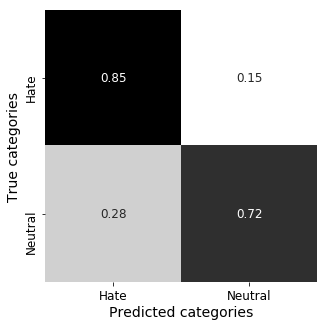

In [165]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Neutral']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

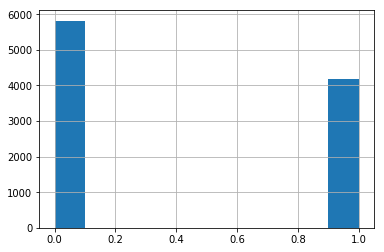

In [166]:
y.hist()

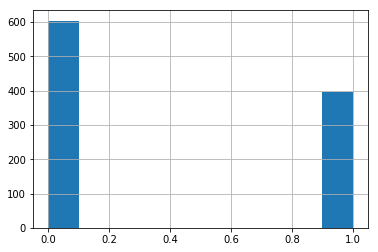

In [167]:
pd.Series(y_preds).hist()

In [168]:
#get wrong prediction

for text, prediction, label in zip(X_test, y_preds, y_test):
    if prediction != label:
        print(text, '*** has been classified as ', prediction, 'and should be ', label) 


20 *** has been classified as  0 and should be  1
25 *** has been classified as  0 and should be  1
28 *** has been classified as  1 and should be  0
36 *** has been classified as  0 and should be  1
54 *** has been classified as  1 and should be  0
56 *** has been classified as  0 and should be  1
61 *** has been classified as  1 and should be  0
65 *** has been classified as  0 and should be  1
66 *** has been classified as  0 and should be  1
67 *** has been classified as  1 and should be  0
68 *** has been classified as  0 and should be  1
73 *** has been classified as  1 and should be  0
82 *** has been classified as  1 and should be  0
85 *** has been classified as  1 and should be  0
87 *** has been classified as  0 and should be  1
89 *** has been classified as  0 and should be  1
90 *** has been classified as  0 and should be  1
94 *** has been classified as  1 and should be  0
96 *** has been classified as  0 and should be  1
107 *** has been classified as  0 and should be  1